# Final Project Report
### *Solving the N-Body Problem Numerically Using a Lagrangian Approach*

**Author:** Xander Carroll    
**Course:** Physics 5300, Autumn 2025  
**Date:** December 6, 2025

**Project Repository:** [Link](https://github.com/Xander-Carroll/PHYSICS5300-NBody-Final)

---

## 0. Library Imports

In [1]:
# External library includes
import matplotlib.pyplot as plt
import numpy as np

## 1. Physical Problem

### A. Project Proposal

I will build a numerical solver for the N-Body gravitational problem. I will implement a timestep integrator such as leapfrog, verify the behavior on simple systems (e.g., two-body orbits), and then run larger simulations to examine stability and emergent structure. If time allows, I would like to examine the problem for large values of N (~$10^4$ bodies). The resulting trajectories will be visualized using Manim or a similar animation tool. All code, animations, and documentation will be organized in a GitHub repository. There are a large number of resources (papers and pre-existing projects) for this problem. There is also great documentation for the python libraries we have been using.

### B. Describe the System

PLOTS SHOWING THE SYSTEM WITH COORDINATES ETC, ETC

In [2]:
# Code to generate descriptive plots.

### C.1. Determining the Lagrangian

The potential and kinetic energy of the system needs to be described in terms of $\mathbf{r}_i$ and $\dot{\mathbf{r}}_i$ (the position and velocities of each body):

$$ T = \sum_{i=1}^{N} \dfrac{1}{2} m_i |\dot{\mathbf{r}_i}|^2 $$
$$ U = -G \sum_{i=1}^{N} \sum_{j>i}^{N} \dfrac{m_i m_j}{|\mathbf{r}_i - \mathbf{r}_j|}$$

Which we can then use to describe the Lagrangian:

$$ L = T - U = \sum_{i=1}^{N} \dfrac{1}{2} m_i |\dot{\mathbf{r}_i}|^2 + G \sum_{i=1}^{N} \sum_{j>i}^{N} \dfrac{m_i m_j}{|\mathbf{r}_i - \mathbf{r}_j|}$$

### C.2. Determining the Equations of Motion

We can find the following derivatives:

$$ \dfrac{\partial L}{\partial \mathbf{r}_i} = - G \sum_{j \ne i} \dfrac{m_i m_j (\mathbf{r}_i - \mathbf{r}_j)}{|\mathbf{r}_i - \mathbf{r}_j|^3}$$
$$ \dfrac{d}{dt} \dfrac{\partial L}{\partial \dot{\mathbf{r}}_i} = \dfrac{d}{dt} \big[m_i \dot{\mathbf{r}}_i\big] = m_i \ddot{\mathbf{r}}_i$$

Using the Euler-Lagrange equations for each coordinate body:

$$ \dfrac{d}{dt} \dfrac{\partial L}{\partial \dot{\mathbf{r}}_i} - \dfrac{\partial L}{\partial \mathbf{r}_i} = 0$$

Gives us the following Newtonian acceleration:

$$ m_i \ddot{\mathbf{r}}_i = - G \sum_{j \ne i} \dfrac{m_i m_j (\mathbf{r}_i - \mathbf{r}_j)}{|\mathbf{r}_i - \mathbf{r}_j|^3} $$

Which can be written as:

$$ \ddot{\mathbf{r}}_i = - G \sum_{j \ne i} \dfrac{m_j (\mathbf{r}_i - \mathbf{r}_j)}{|\mathbf{r}_i - \mathbf{r}_j|^3} $$

### D.1. Assumptions

The first assumption is an idealized system. The bodies will be treated as point masses, interacting solely via Newtonian gravitation. Relativistic effects, internal structure, collisions, and other forces will not be considered. 

The second assumption is dimensionality. We can simplify the problem by assuming that the orbits occur in a two-dimensional plane, rather than in three-dimensional space.


### D.2. Symmetries 

The Lagrangian has several symmetries:
- **Time:** because $L$ has no explicit dependence on $t$.
- **Translation:** because $L$ only depends on relative positions.
- **Rotation:** because rotating the system does not change $L$.

These symmetries imply that the *Energy*, *Linear Momentum*, and *Angular Momentum* of the system are conserved.



---

## 2. Visualizations

### A.1. Numerical Integration

For the equations of motion given in `1.C.2`, our acceleration depends only on position. 

We can use an implementation of leapfrog integration to solve the equations of motion numerically. The leapfrog algorithm updates the velocity by a half step, then updates the position, then updates the velocity by a half step. The algorithm is *time-reversal invariant*, so it guarantees conservation of energy.

$$ \mathbf{v}_{i+1/2} = \mathbf{v}_i + \mathbf{a}(\mathbf{r}_i)  \Delta t/2 $$
$$ \mathbf{r}_{i+1} = \mathbf{r}_i +  \mathbf{v}_{i+1/2}  \Delta t  $$
$$ \mathbf{v}_{i+1} = \mathbf{v}_{i+1/2} + \mathbf{a}(\mathbf{r}_{i+1})  \Delta t/2 $$

In [3]:
def accelerations(r, m, G=1.0, eps=1e-3):
    """
    Given the position of each body, computes the acceleration using the equations of motion.
    
    Parameters
    ----------
    r   : float tuple array : positions [(rx1, ry1, rz1), ...]
    m   : float array       : masses [m1, m2, ...]
    G   : float             : gravitational constant
    eps : float             : softening parameter

    Return
    ----------
    return : float tuple array : accelerations [(ax1, ay1, az1), ...]
    """

    # Compute ri - rj.
    rij = r[:, None, :] - r[None, :, :]

    # Compute the 1/rij^3 between all pairs (with eps as a softening parameter).
    d3 = (np.sum(rij**2, axis=-1) + eps**2) ** -1.5

    # Compute acceleration.
    a = np.sum((-G * m[None, :] * d3)[:, :, None] * rij, axis=1)

    return a

def leapfrog_solve(r0, v0, m, t_pts, G=1.0, eps=1e-3):
    """
    Returns filled arrays r0 and v0 which correspond to each time step in t_pts.
    
    Parameters
    ----------
    r0      : float tuple array : initial positions [(rx1, ry1, rz1), ...]
    v0      : float tuple array : initial velocities [(vx1, vy1, vz1), ...]
    m       : float array       : masses [m1, m2, ...]
    t_pts   : float array       : an array of evenly spaced time steps when positions and velocites should be found.
    G       : float             : gravitational constant
    eps     : float             : softening parameter

    Return
    ----------
    return[0] : float tuple array : positions [(rx1, ry1, rz1), ...]
    return[1] : float tuple array : velocities [(vx1, vy1, vz1), ...]
    """

    # Convert the input to numpy arrays.
    m = np.array(m)
    r0 = np.array(r0, dtype=float)
    v0 = np.array(v0, dtype=float)

    # Sanity check.
    if len(r0) != len(v0):
        print("[ERROR]: The position array and velocity array must have the same number of bodies!")
        return None, None

    # Determine the time-step.
    dt = t_pts[1] - t_pts[0]

    # Initalize the arrays.
    n, dim = r0.shape
    nt = len(t_pts)

    r = np.zeros((nt, n, dim))
    v = np.zeros((nt, n, dim))

    # Use the initial conditions.
    r[0] = r0
    v[0] = v0

    # Apply the leapfrog algorithm.
    for i in np.arange(nt-1):
        v_half = v[i] + accelerations(r[i], m, G, eps) * dt * 0.5       # Update the velocity by a half step.
        r[i+1] = r[i] + v_half * dt                                     # Update the position.
        v[i+1] = v_half + accelerations(r[i+1], m, G, eps) * dt * 0.5   # Update the velocity by a half step.

    # Return the updated results.
    return r, v

## A.2. Plots of Different Orbits

We can plot the orbits for many different two dimensional casses. Consider these cases:
- Two bodies of equal mass orbiting in a circle
- Three bodies in a stable periodic orbit 

In [24]:
def plot_orbits(r, title):
    plt.figure(figsize=(6,6))

    for i in range(len(r[0])): plt.plot(r[:,i,0], r[:,i,1], label=f'Body {i+1}', linestyle='--')

    plt.xlabel('x')
    plt.ylabel('y')
    plt.title(title)
    plt.axis('equal')
    plt.legend()
    plt.show()

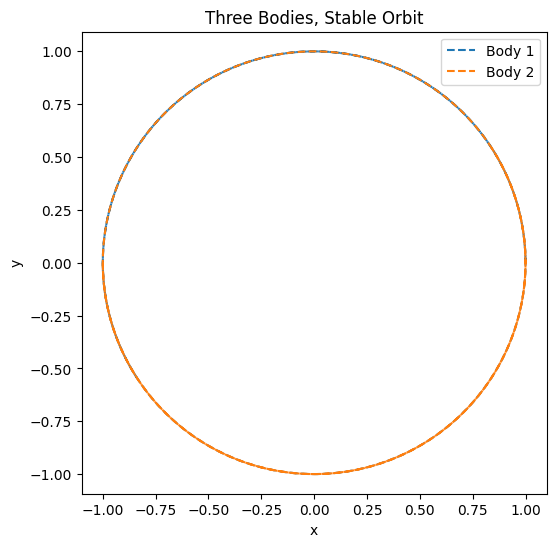

In [25]:
## Two Bodies in a circle.

# Initial conditions for each body.
m = [1.0, 1.0]
r0 = [[1.0, 0.0], [-1.0, 0.0]]
v0 = [[0.0, 0.5], [0.0, -0.5]]

# Solve the problem.
t_pts = np.linspace(0, 20, 2000)
r, v = leapfrog_solve(r0, v0, m, t_pts, G=1.0, eps=1e-3)

# Plot the results.
plot_orbits(r, "Three Bodies, Stable Orbit")

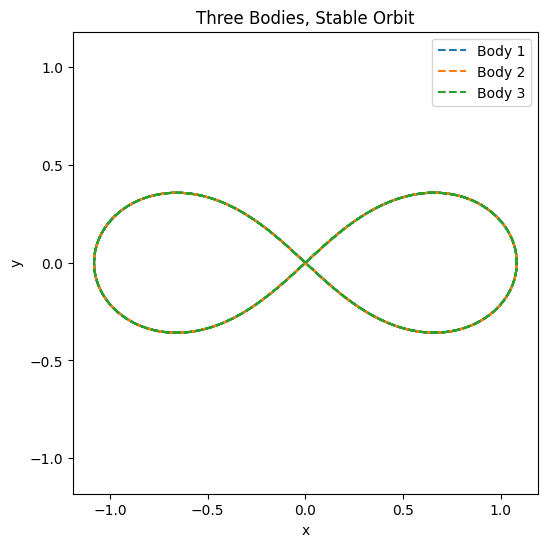

In [26]:
## Three Bodies in a Stable Orbit

# Initial conditions for each body.
m = [1.0, 1.0, 1.0]
r0 = [[-0.970004,  0.243087, 0.0], [ 0.970004, -0.243087, 0.0], [ 0.000000,  0.000000, 0.0]]
v0 = [[-0.466203, -0.432365, 0.0], [-0.466203, -0.432365, 0.0], [ 0.932407,  0.864731, 0.0]]

# Solve the problem.
t_pts = np.linspace(0, 20, 2000)
r, v = leapfrog_solve(r0, v0, m, t_pts, G=1.0, eps=1e-3)

# Plot the results.
plot_orbits(r, "Three Bodies, Stable Orbit")